In [1]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('') 


In [3]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))


In [6]:
# Construct full path to the merged BED file containing all lab-reported peaks
data_path = os.path.join(project_root, 'data', 'lab_reported_data', 'processed_files', 'all_merged_results_from_lab_reported_data.bed')

# Load the merged BED file into a DataFrame
# Expected format: [chr, start, end, label] with no header
all_merged_peaks = pd.read_csv(data_path, sep='\t', header=None)

# Print the total number of merged peaks across all datasets
print(len(all_merged_peaks))

# Group and count the number of entries per label (e.g., active/inactive per dataset)
# Column 3 contains dataset labels like 'LentiMPRA_ENCSR382BVV_active', etc.
print(all_merged_peaks.groupby([3]).size())



526382
3
ATAC_STARR_ENCSR312UQM_active       46906
ATAC_STARR_ENCSR312UQM_inactive    285796
LentiMPRA_ENCSR382BVV_active        56840
LentiMPRA_ENCSR382BVV_inactive      80525
TilingMPRA_ENCSR363XER_active        8379
TilingMPRA_ENCSR363XER_inactive      3712
TilingMPRA_ENCSR394HXI_active         121
TilingMPRA_ENCSR394HXI_inactive       164
TilingMPRA_ENCSR917SFD_active        4419
TilingMPRA_ENCSR917SFD_inactive       849
WHG_STARR_ENCSR661FOW_active        38671
dtype: int64


In [7]:
# ---------------------------------------------------------------
# Extract active peaks from each individual dataset by label
# ---------------------------------------------------------------

# Subset LentiMPRA active peaks based on dataset label
lenti_peak = all_merged_peaks[(all_merged_peaks[3] == 'LentiMPRA_ENCSR382BVV_active')]
print(len(lenti_peak))  # Print number of LentiMPRA active peaks

# Subset Tiling MPRA active peaks by combining peaks from three experiments
tiling_peak = all_merged_peaks[(all_merged_peaks[3].map(lambda x: x in [
    'TilingMPRA_ENCSR363XER_active',  # OL45
    'TilingMPRA_ENCSR394HXI_active',  # OL13
    'TilingMPRA_ENCSR917SFD_active'   # OL43
]))]
print(len(tiling_peak))  # Print number of Tiling MPRA active peaks

# Subset ATAC-STARR-seq active peaks
atac_starr_peak = all_merged_peaks[(all_merged_peaks[3] == 'ATAC_STARR_ENCSR312UQM_active')]
print(len(atac_starr_peak))  # Print number of ATAC-STARR active peaks

# Subset WHG-STARR-seq active peaks
whg_starr_peak = all_merged_peaks[(all_merged_peaks[3] == 'WHG_STARR_ENCSR661FOW_active')]
print(len(whg_starr_peak))  # Print number of WHG-STARR active peaks


56840
12919
46906
38671


In [20]:
def calculate_interval_overlaps(d1, d2):
    """
    Perform BEDTools intersection between two BedTool objects, keeping the number of overlapping base pairs.

    Args:
        d1 (BedTool): First interval set.
        d2 (BedTool): Second interval set.

    Returns:
        pd.DataFrame: Intersected intervals with overlap length as the last column.
    """
    # Perform intersection with base pair overlap information
    intersect = d1.intersect(d2, wo=True)
    intersect = intersect.to_dataframe(disable_auto_names=True, header=None)

    # Sort and remove duplicate entries from d1
    if len(intersect) > 0:
        intersect = intersect.sort_values(intersect.columns[-1], ascending=False)
        intersect = intersect.drop_duplicates([0, 1, 2, 3])  # deduplicate based on d1's key columns

    return intersect


def filter_by_minimum_overlap_bp(comp_df, bp_cutoff):
    """
    Filter overlaps to retain only those with at least a minimum base-pair overlap.

    Args:
        comp_df (pd.DataFrame): Overlap dataframe from `calculate_interval_overlaps`.
        bp_cutoff (int): Minimum number of base pairs required to retain the overlap.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        comp_df = comp_df[comp_df[8] >= bp_cutoff]  # column 8 = number of overlapping bp
    else:
        comp_df = pd.DataFrame(columns=[x for x in range(0, 9)] + ['class', 'pct_overlap_1', 'pct_overlap_2'])

    return comp_df


def filter_by_minimum_overlap_pct(comp_df, pct_cutoff, reciprocal=True):
    """
    Filter overlaps based on minimum percentage overlap (reciprocal or not).

    Args:
        comp_df (pd.DataFrame): Overlap dataframe with percent overlap calculated.
        pct_cutoff (float): Minimum percent overlap to consider.
        reciprocal (bool): If True, require both overlaps to pass cutoff; if False, either.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        if reciprocal:
            comp_df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) & 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ]
        else:
            comp_df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) | 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ]
    else:
        comp_df = pd.DataFrame(columns=[x for x in range(0, 9)] + ['class', 'pct_overlap_1', 'pct_overlap_2'])

    return comp_df

def compute_pairwise_overlap_stats(peak_1, peak_2):
    """
    Compare two peak datasets and calculate the overlapping regions between them.

    Args:
        peak_1 (pd.DataFrame): BED-like DataFrame for the first dataset [chr, start, end, name...]
        peak_2 (pd.DataFrame): BED-like DataFrame for the second dataset

    Returns:
        pd.DataFrame: Overlapping regions with overlap length and percent overlap for both sets.
    """
    # Sort both peak lists by chromosome and start position
    peak_1 = peak_1.sort_values([0, 1])
    peak_2 = peak_2.sort_values([0, 1])

    # Calculate peak sizes
    peak_1['size'] = peak_1[2] - peak_1[1]
    peak_2['size'] = peak_2[2] - peak_2[1]

    # Convert to BedTool objects
    peak_1_bed = pybedtools.BedTool.from_dataframe(peak_1)
    peak_2_bed = pybedtools.BedTool.from_dataframe(peak_2)

    # Perform intersection
    peak_1_vs_peak_2 = calculate_interval_overlaps(peak_1_bed, peak_2_bed)

    if len(peak_1_vs_peak_2) > 0:
        peak_1_vs_peak_2['class'] = 'active'
    else:
        # Create empty DataFrame with expected structure
        peak_1_vs_peak_2 = pd.DataFrame(columns=[x for x in range(0, 9)], index=[])
        peak_1_vs_peak_2['class'] = 'active'

    # Remove duplicate overlaps and sort by overlap length (column 8)
    comp_df = peak_1_vs_peak_2.sort_values([8], ascending=False)
    comp_df = comp_df.drop_duplicates([0, 1, 2, 3])

    # Compute percent overlap for each peak set
    comp_df['pct_overlap_1'] = comp_df[8] / comp_df[3] * 100
    comp_df['pct_overlap_2'] = comp_df[8] / comp_df[7] * 100

    return comp_df


def record_overlap_count(comp_df, call_df, dataset_1, dataset_2):
    """
    Record the number of overlapping regions labeled 'active' into a comparison matrix.

    Args:
        comp_df (pd.DataFrame): Output from compute_pairwise_overlap_stats
        call_df (pd.DataFrame): Matrix to store overlap counts
        dataset_1 (str): Name of row dataset
        dataset_2 (str): Name of column dataset
    """
    count = len(comp_df[comp_df['class'] == 'active'])
    call_df.loc[dataset_1, dataset_2] = count
    
def compute_pairwise_peak_overlap(peak_df_list, dataset_list):
    """
    Compute pairwise comparisons of peak overlaps between datasets.

    This function compares each dataset's peak list to every other dataset's peak list
    and computes two types of overlaps:
        1. Any 1bp overlap
        2. 50% reciprocal overlap

    Args:
        peak_df_list (List[pd.DataFrame]): List of BED-like DataFrames, one per dataset.
        dataset_list (List[str]): List of dataset names, matching the order of peak_df_list.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]:
            - DataFrame of 1bp overlaps
            - DataFrame of 50% reciprocal overlaps
    """
    
    # Initialize empty DataFrames for storing overlap counts
    comp_df_1bp = pd.DataFrame(columns=dataset_list, index=dataset_list)
    comp_df_50pct_reciprocal = pd.DataFrame(columns=dataset_list, index=dataset_list)

    # Loop over all pairs of datasets
    for i in range(len(peak_df_list)):
        for j in range(len(peak_df_list)):
            peak_1 = peak_df_list[i]
            peak_2 = peak_df_list[j]

            dataset_1 = dataset_list[i]
            dataset_2 = dataset_list[j]

            # Self-comparison: fill diagonal with total number of peaks
            if i == j:
                comp_df_1bp.loc[dataset_1, dataset_2] = len(peak_1)
                comp_df_50pct_reciprocal.loc[dataset_1, dataset_2] = len(peak_1)

            else:
                # Compute pairwise overlaps
                comp_df = compute_pairwise_overlap_stats(peak_1, peak_2)

                # Compute 1bp overlap count and fill in matrix
                overlap_1bp = filter_by_minimum_overlap_bp(comp_df, bp_cutoff=1)
                record_overlap_count(overlap_1bp, comp_df_1bp, dataset_1, dataset_2)

                # Compute 50% reciprocal overlap count and fill in matrix
                overlap_50pct_reciprocal = filter_by_minimum_overlap_pct(comp_df, pct_cutoff=50, reciprocal=True)
                record_overlap_count(overlap_50pct_reciprocal, comp_df_50pct_reciprocal, dataset_1, dataset_2)

    return [comp_df_1bp, comp_df_50pct_reciprocal]

def compute_jaccard_index(pairwise_overlap_matrix, dataset_1, dataset_2):
    """
    Compute Jaccard index between two datasets based on their pairwise overlap matrix.
    
    Jaccard index = Intersection / Union
                  = shared peaks / (total peaks in both - shared peaks)
    
    Args:
        pairwise_overlap_matrix (pd.DataFrame): matrix of overlapping peak counts between datasets
        dataset_1 (str): name of the first dataset
        dataset_2 (str): name of the second dataset

    Returns:
        float: Jaccard index between dataset_1 and dataset_2
    """
    total_1 = pairwise_overlap_matrix.loc[dataset_1, dataset_1]
    total_2 = pairwise_overlap_matrix.loc[dataset_2, dataset_2]

    shared_1 = pairwise_overlap_matrix.loc[dataset_1, dataset_2]
    shared_2 = pairwise_overlap_matrix.loc[dataset_2, dataset_1]

    shared_peaks = np.max([shared_1, shared_2])

    return shared_peaks / (total_1 + total_2 - shared_peaks)

def generate_jaccard_index_matrices(dataset_list, overlap_matrices):
    """
    Generate Jaccard index matrices for a list of datasets based on multiple overlap strategies.
    
    For each pair of datasets, compute Jaccard index using their overlap counts
    from corresponding pairwise overlap matrices.

    Args:
        dataset_list (list of str): list of dataset names
        overlap_matrices (list of pd.DataFrame): list of pairwise overlap matrices 
            (e.g. one for 1bp overlap, one for 50% reciprocal overlap)

    Returns:
        list of pd.DataFrame: Jaccard index matrices corresponding to input overlap matrices
    """
    jaccard_index_matrices = []

    for matrix in overlap_matrices:
        jaccard_df = pd.DataFrame(columns=dataset_list, index=dataset_list)

        for i in range(len(dataset_list)):
            for j in range(len(dataset_list)):
                dataset_1 = dataset_list[i]
                dataset_2 = dataset_list[j]

                if i == j:
                    jaccard_df.loc[dataset_1, dataset_2] = 0
                else:
                    jaccard_val = compute_jaccard_index(matrix, dataset_1, dataset_2)
                    jaccard_df.loc[dataset_1, dataset_2] = jaccard_val
                    jaccard_df.loc[dataset_2, dataset_1] = jaccard_val

        jaccard_index_matrices.append(jaccard_df)

    return jaccard_index_matrices


In [21]:
def plot_overlap_percentage_heatmap(overlap_counts_df, title, output_file=''):
    """
    Plot a detailed heatmap showing the number and percentage of overlapping peaks between datasets.

    Args:
        overlap_counts_df (pd.DataFrame): Square matrix where [i, j] = number of peaks in dataset j overlapping with dataset i.
        title (str): Title for the heatmap.
        output_file (str): Path to save the heatmap image (optional).
    """
    # Initialize empty DataFrame to hold overlap percentages
    overlap_pct_df = pd.DataFrame(columns=overlap_counts_df.columns, index=overlap_counts_df.columns)

    for i in overlap_counts_df.columns:
        for j in overlap_counts_df.columns:
            # Calculate % of dataset i covered by dataset j
            if overlap_counts_df.loc[i, j] > 0:
                overlap_pct_df.loc[i, j] = (overlap_counts_df.loc[i, j] / overlap_counts_df.loc[i, i]) * 100
            else:
                overlap_pct_df.loc[i, j] = 0.00

    # Format annotations (number + percentage) for each cell
    annot = overlap_pct_df.applymap("{0:.2f}%".format)
    for col in annot.columns:
        for row in annot.index:
            count = int(overlap_counts_df.loc[row, col])
            annot.loc[row, col] = f"{count:,}\n{annot.loc[row, col]}" if row == col else f"{count:,}\n{annot.loc[row, col]}"

    overlap_pct_df = overlap_pct_df.astype(float)

    # Plot heatmap
    fig = plt.figure(figsize=(10, 10))
    sns.set_style('white')
    cmap = 'YlOrBr'

    ax = sns.heatmap(overlap_pct_df, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                     vmin=0, vmax=100, annot=annot, annot_kws={"fontsize": 17}, fmt='', cbar=True)
    ax.set_title(title, fontsize=20)

    ticks = list(overlap_pct_df.columns)
    ax.set_xticklabels(ticks, fontsize=15, rotation=90)
    plt.yticks(np.arange(len(ticks)) + 0.5, ticks, fontsize=17, rotation=0, va="center")

    cbar = ax.collections[0].colorbar
    cbar.ax.set_yticklabels(['{:.0f}%'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])
    cbar.ax.tick_params(labelsize=17)

    if output_file:
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)


def plot_jaccard_index_heatmap(jaccard_df, title, output_file=''):
    """
    Plot a heatmap showing Jaccard indices between datasets.

    Args:
        jaccard_df (pd.DataFrame): Symmetric matrix of Jaccard indices.
        title (str): Title for the heatmap.
        output_file (str): Path to save the heatmap image (optional).
    """
    annot = jaccard_df.applymap("{0:.2f}".format)
    jaccard_df = jaccard_df.astype(float)

    # Mask upper triangle to avoid redundancy
    mask = np.triu(np.ones_like(jaccard_df, dtype=bool))

    fig = plt.figure(figsize=(8, 8))
    sns.set_style('white')
    cmap = 'YlOrBr'

    ax = sns.heatmap(jaccard_df, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                     vmin=0, vmax=1, annot=annot, annot_kws={"fontsize": 17}, fmt='', cbar=True, mask=mask)
    ax.set_title(title, fontsize=20)

    ticks = list(jaccard_df.columns)
    ax.set_xticklabels(ticks, fontsize=17, rotation=90)
    plt.yticks(np.arange(len(ticks)) + 0.5, ticks, fontsize=17, rotation=0, va="center")

    cbar = ax.collections[0].colorbar
    cbar.ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])
    cbar.ax.tick_params(labelsize=17)

    if output_file:
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)
        

<ipython-input-21-cf3124a85e73>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])
<ipython-input-21-cf3124a85e73>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])
<ipython-input-21-cf3124a85e73>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])
<ipython-input-21-cf3124a85e73>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in cbar.ax.get_yticklabels()])


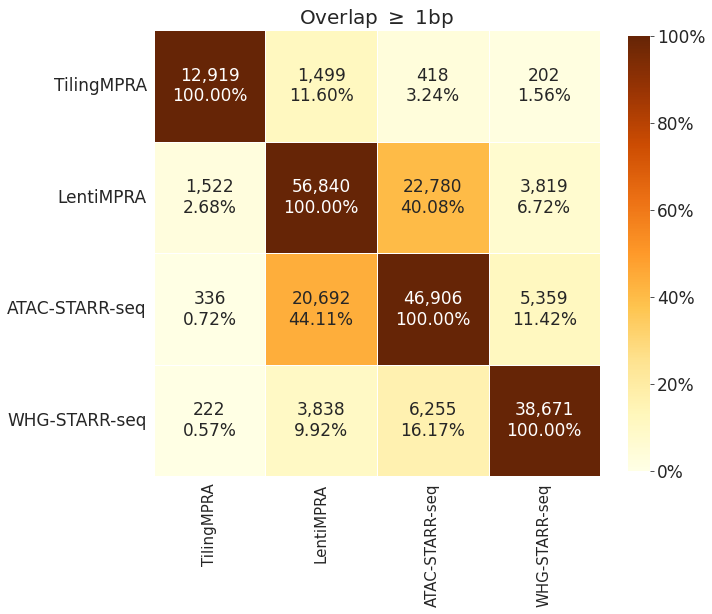

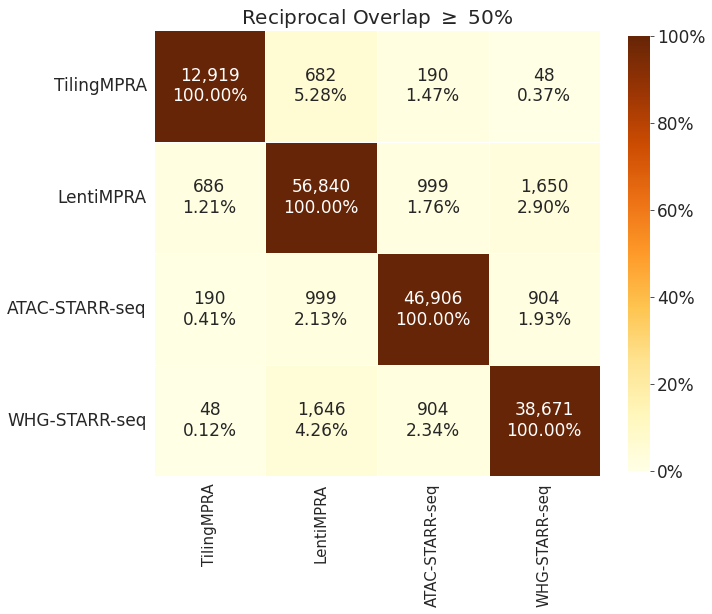

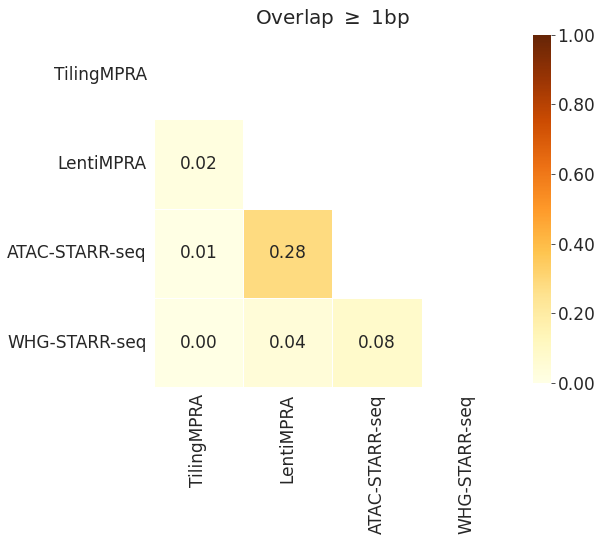

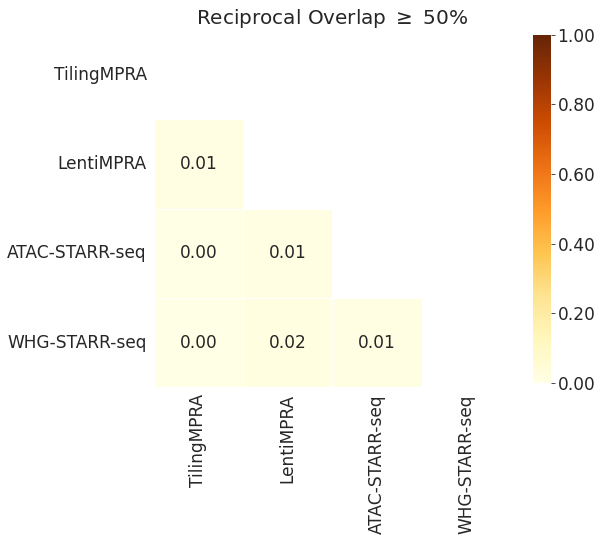

In [22]:
# -------------------------------------------
# Set plot title strings for overlap metrics
# -------------------------------------------
overlap_1bp_title_prefix = 'Overlap ' + u'$\geq$ ' + '1bp'
reciprocal_50pct_title_prefix = 'Reciprocal Overlap ' + u'$\geq$ ' + '50%'

# -------------------------------------------
# Prepare peak DataFrames for each dataset
# -------------------------------------------
peak_df_list = [
    tiling_peak[[0, 1, 2]].drop_duplicates([0, 1, 2]),
    lenti_peak[[0, 1, 2]].drop_duplicates([0, 1, 2]),
    atac_starr_peak[[0, 1, 2]].drop_duplicates([0, 1, 2]),
    whg_starr_peak[[0, 1, 2]].drop_duplicates([0, 1, 2])
]

dataset_list = ['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# -------------------------------------------
# Compute pairwise peak overlaps:
# [0] = 1bp overlap
# [1] = 50% reciprocal overlap
# -------------------------------------------
overlap_summary_matrices = compute_pairwise_peak_overlap(peak_df_list, dataset_list)

# -------------------------------------------
# Compute Jaccard index matrices based on overlaps
# -------------------------------------------
jaccard_index_matrices = generate_jaccard_index_matrices(dataset_list, overlap_summary_matrices)

# -------------------------------------------
# Plot heatmaps (display only, no saving)
# -------------------------------------------

# 1bp overlap: counts + %
plot_overlap_percentage_heatmap(overlap_summary_matrices[0], overlap_1bp_title_prefix)

# 50% reciprocal overlap: counts + %
plot_overlap_percentage_heatmap(overlap_summary_matrices[1], reciprocal_50pct_title_prefix)

# 1bp overlap Jaccard index
plot_jaccard_index_heatmap(jaccard_index_matrices[0], overlap_1bp_title_prefix)

# 50% reciprocal overlap Jaccard index
plot_jaccard_index_heatmap(jaccard_index_matrices[1], reciprocal_50pct_title_prefix)
